In [1]:
from snake_env_12in_turn import SnakeEnvTurn
import datetime
import random
import numpy as np
from keras import Sequential
from collections import deque
from keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from plot_script import plot_result
import time


class DQN:

    """ Deep Q Network """

    def __init__(self, env, params):

        self.action_space = env.action_space
        self.state_space = env.state_space
        self.epsilon = params['epsilon'] 
        self.gamma = params['gamma'] 
        self.batch_size = params['batch_size'] 
        self.epsilon_min = params['epsilon_min'] 
        self.epsilon_decay = params['epsilon_decay'] 
        self.learning_rate = params['learning_rate']
        self.layer_sizes = params['layer_sizes']
        self.model_name = params['name']
        self.memory = deque(maxlen=2500)
        self.model = self.build_model()


    def build_model(self):
        model = Sequential()
        for i in range(len(self.layer_sizes)):
            if i == 0:
                model.add(Dense(self.layer_sizes[i], input_shape=(self.state_space,), activation='relu'))
            else:
                model.add(Dense(self.layer_sizes[i], activation='relu'))
        model.add(Dense(self.action_space, activation='softmax'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate),metrics='mae')
        print(model.summary())
        return model


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state,verbose=0)
        return np.argmax(act_values[0])


    def replay(self):

        if len(self.memory) < 2:
            return [0],[0]
        
        if len(self.memory) < self.batch_size:
            l = len(self.memory)
        else:
            l = self.batch_size
            
        minibatch = random.sample(self.memory, l)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(l)])
        targets_full[[ind], [actions]] = targets

        history = self.model.fit(states, targets_full, epochs=1, verbose=0)
        loss = history.history['loss']
        mae = history.history['mae']
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss, mae


def train_dqn(episode, env,agent):

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/dqn/' + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    sum_of_rewards = []
    
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, env.state_space))
        score = 0
        max_steps = 10000
        food_count = 0
        for i in range(max_steps):
            action = agent.act(state)
            # print(action)
            prev_state = state
            next_state, reward, done, _ = env.step(action)
            if reward == 10:
                food_count += 1
            score += reward
            next_state = np.reshape(next_state, (1, env.state_space))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if params['batch_size'] > 1:
                loss,mae = agent.replay()
            if done:
                print(f'final state before dying: {str(prev_state)}')
                print(f'episode: {e+1}/{episode}, score: {score}')
                break
        episode_steps = i
        episode_reward = score
        with train_summary_writer.as_default():
            tf.summary.scalar("Total episode reward",episode_reward,step=e)
            tf.summary.scalar("Total episode steps",episode_steps,step=e)
            tf.summary.scalar("Food eaten in episode",food_count,step=e)
            tf.summary.scalar("mae",mae[0],step=e)
            tf.summary.scalar("loss",loss[0],step=e)
        
        sum_of_rewards.append(score)
        if e == 0 or e == 4 or e == 20 or e == 49:
            agent.model.save_weights(f"{agent.model_name} ep {e}.h5f",overwrite=True)
    return sum_of_rewards



In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
params = dict()
params['name'] = 'elite_memory'
params['epsilon'] = 0.01
params['gamma'] = .95
params['batch_size'] = 500
params['epsilon_min'] = .01
params['epsilon_decay'] = .995
params['learning_rate'] = 0.00025
params['layer_sizes'] = [128, 128, 128]

results = dict()
ep = 50

# for batchsz in [1, 10, 100, 1000]:
#     print(batchsz)
#     params['batch_size'] = batchsz
#     nm = ''
#     params['name'] = f'Batchsize {batchsz}'
env_infos = {'States: only walls':{'state_space':'no body knowledge'}, 'States: direction 0 or 1':{'state_space':''}, 'States: coordinates':{'state_space':'coordinates'}, 'States: no direction':{'state_space':'no direction'}}

# for key in env_infos.keys():
#     params['name'] = key
#     env_info = env_infos[key]
#     print(env_info)
#     env = Snake(env_info=env_info)
env_info = {"state_space" : "no direction"}
# env = SnakeEnv((20, 20),(10,10),1)
env = SnakeEnvTurn((20, 20),(10,10),1)
# env = Snake()
agent = DQN(env, params)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 35,075
Trainable params: 35,075
Non-trainable params: 0
_________________________________________________________________
None


c:\Users\PC\Anaconda3\envs\snake-game\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
#pretrain 
import pandas as pd

df = pd.read_csv("state_and_action_data.csv")

data_x = df.copy().drop(["action_left","action_forward","action_right"],axis=1)
data_y = df[["action_left","action_forward","action_right"]]


In [4]:
data_x.head()

,food_up,food_down,food_right,food_left,obs_up,obs_down,obs_left,obs_right,dir_up,dir_down,dir_right,dir_left
0,0,1,1,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,0,0,0,0,1,0,0
3,1,0,1,0,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,0,0,0,1


In [5]:
xs = data_x.to_numpy()
ys = data_y.to_numpy()


In [6]:
agent.model.fit(xs,ys,batch_size=500,epochs=100,verbose=1)

Epoch 1/100
60/60 [==============================] - 0s 2ms/step - loss: 0.1348 - mae: 0.3026
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0901 - mae: 0.1804
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0859 - mae: 0.1842
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0817 - mae: 0.1794
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0785 - mae: 0.1690
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0761 - mae: 0.1621
Epoch 7/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1561
Epoch 8/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0736 - mae: 0.1513
Epoch 9/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0733 - mae: 0.1500
Epoch 10/100
60/60 [==============================] - 0s 2ms/step - loss: 0.0729 - mae: 0.1495
Epoch 11/100
60/60 [==============================] - 0s 2m

In [7]:
# from keras.callbacks import TensorBoard
# from tensorflow import keras
# %load_ext tensorboard
# %tensorboard --logdir logs/dqn

In [8]:
df_memory = pd.read_csv("memory_data.csv")
sample = df_memory.sample(2500)
df_memory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21626 entries, 0 to 21625
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state       21626 non-null  object
 1   actions     21626 non-null  int64 
 2   reward      21626 non-null  int64 
 3   next_state  21626 non-null  object
 4   done        21626 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 865.9+ KB


In [9]:
df_memory = pd.read_csv("memory_data_elite.csv")
sample = df_memory.sample(2500)
df_memory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4518 entries, 2664 to 21363
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state       4518 non-null   object
 1   actions     4518 non-null   int64 
 2   reward      4518 non-null   int64 
 3   next_state  4518 non-null   object
 4   done        4518 non-null   bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 180.9+ KB


In [10]:
import json
get_state = lambda i : np.array(json.loads(df_memory.iloc[i]['state'].replace(' ',',')))
get_nstate = lambda i : np.array(json.loads(df_memory.iloc[i]['next_state'].replace(' ',',')))

In [11]:
for i in range(2500):
    state = get_state(i)
    state = np.reshape(state, (1, env.state_space))
    nstate = get_nstate(i)
    nstate = np.reshape(nstate, (1, env.state_space))
    action = df_memory.iloc[i]['actions']
    reward = df_memory.iloc[i]['reward']
    done = df_memory.iloc[i]['done']
    agent.memory.append(((state, action, reward, nstate, done)))

93668
final state before dying: [[0 1 0 1 1 1 1 0 0 0 0 1]]
episode: 1/50, score: 275
39110
final state before dying: [[1 0 0 0 0 1 0 1 0 1 0 0]]
episode: 2/50, score: 263
73643
final state before dying: [[1 0 0 1 1 0 1 1 1 0 0 0]]
episode: 3/50, score: 146
84356
final state before dying: [[1 0 0 1 0 0 1 0 1 0 0 0]]
episode: 4/50, score: 397
1513
final state before dying: [[0 1 0 1 1 0 0 0 0 0 0 1]]
episode: 5/50, score: 204
28523
final state before dying: [[0 1 0 1 0 0 0 1 1 0 0 0]]
episode: 6/50, score: 188
57494
final state before dying: [[1 0 1 0 1 1 0 1 0 0 1 0]]
episode: 7/50, score: 394
60204
final state before dying: [[0 1 0 0 0 1 0 0 0 0 0 1]]
episode: 8/50, score: 118
18969
final state before dying: [[0 1 0 1 0 1 1 1 0 1 0 0]]
episode: 9/50, score: 71
70528
final state before dying: [[0 1 1 0 0 1 0 0 0 0 1 0]]
episode: 10/50, score: -60
29501
final state before dying: [[0 0 0 1 0 0 1 0 0 0 0 1]]
episode: 11/50, score: 41
48459
final state before dying: [[0 0 1 0 0 1 0 1 0 0 1

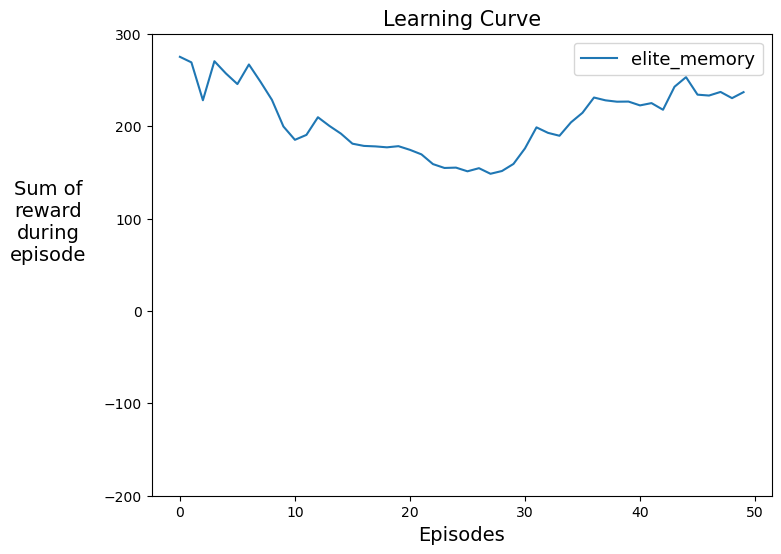

In [12]:
sum_of_rewards = train_dqn(ep, env,agent=agent)
results[params['name']] = sum_of_rewards

plot_result(results, direct=True, k=20)